In [31]:
import numpy as np
import pandas as pd
import openpyxl as xl
import FILibExcel
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
import xgboost as xgb 
import shap

In [65]:
excel_path = r"../../static/mock/antibio_data/20.02.2024 AntiBio_дополнено.xlsx"
artifacts_path = r"../../static/mock/antibio_artifacts/20-02/"

## Data Processing

In [66]:
tables_dict = FILibExcel.get_all_tables(file_name=excel_path)
df_compounds = tables_dict["CompoundsData"]['dataframe']
df_bacterias = tables_dict["BacteriasData"]['dataframe']
df_experiments = tables_dict["ExperimentsData"]['dataframe']


worksheet name: Table
tables in worksheet: 0

worksheet name: CompoundsData
tables in worksheet: 1
table name: CompoundsData

worksheet name: BacteriasData
tables in worksheet: 1
table name: BacteriasData

worksheet name: pH and concentration
tables in worksheet: 0

worksheet name: ExperimentsData
tables in worksheet: 1
table name: ExperimentsData

worksheet name: Legend-Main
tables in worksheet: 0

worksheet name: Bac
tables in worksheet: 0


In [67]:
# One hot encoding
types_num = 9
crystal_structure_names = []


for i in range(1, types_num + 1):
    new_name = f'Crystal structure type {i}'
    df_compounds[new_name] = 0
    crystal_structure_names.append(new_name)

for index, _ in df_compounds.iterrows():
    item = df_compounds.loc[index]
    if pd.isna(item['Crystal structure type']):
        if not pd.isna(item['Crystal structure type (literat.)']):
            i = int(item['Crystal structure type (literat.)'])
            df_compounds.loc[index, f'Crystal structure type {int(i)}'] = 1
        continue
        

    for i in str(item['Crystal structure type']).split(';'):
        df_compounds.loc[index, f'Crystal structure type {int(i)}'] = 1
df_compounds[crystal_structure_names]

,Crystal structure type 1,Crystal structure type 2,Crystal structure type 3,Crystal structure type 4,Crystal structure type 5,Crystal structure type 6,Crystal structure type 7,Crystal structure type 8,Crystal structure type 9
0,1,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0
5,0,0,1,0,0,0,0,0,0
6,0,1,0,0,0,0,0,0,0
7,0,0,1,0,0,0,0,0,0
8,0,1,0,0,0,0,0,0,0
9,0,1,0,0,0,0,0,0,0


In [68]:
df = df_experiments.merge(df_compounds, left_on='REE', right_on='REE').merge(df_bacterias, left_on='Bacteria', right_on='Name')
df.head().columns

Index(['REE', 'Bacteria', 'Salt/Solution', 'Stunting diameter', 'Ionic radii',
       '1st Ionization energy', '2nd Ionization energy',
       '3rd Ionization energy', '4th Ionization energy',
       'Crystal structure type', 'Crystal structure type (literat.)',
       '(salt)  d1-1H2O', '(salt)  d1-2H2O', '(salt)  d1-3H2O',
       '(salt) d1-4H2O', '(salt)  d1-5H2O', '(salt) d1-1NO3', '(salt) d1-2NO3',
       '(salt) d1-3NO3', '(salt) d1-4NO3', '(salt) d1-5NO3', '(salt) d1-6NO3',
       '(salt) d1', '(salt) d2-1NO3', '(salt) d2-2NO3', '(salt) d2-3NO3',
       '(salt) d3-1H2O', '(salt) d3-2H2O', 'Coordination number (solid) Ln-O',
       'Coordination number (solid) Ln-N', 'x', 'n',
       'Electronegativity, Oganov', 'Electronegativity, Malliken',
       'Electronegativity, Poland', 'Electronegativity, Allred-Rochow',
       'R1 (Ln-O)', 'R1 (Ln-N)', 'R2 (Ln-O)',
       'Coordination number solution 1(Ln-O)',
       'Coordination number solution  1(Ln-N)',
       'Coordination number 

In [69]:
df = df.drop(['REE', 'Bacteria', 'Name', 'Electronic structure RE3+', 'Price', 'Name', 'Crystal structure type', 'Crystal structure type (literat.)'], axis=1)

In [70]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245 entries, 0 to 244
Data columns (total 63 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Salt/Solution                          245 non-null    int64  
 1   Stunting diameter                      245 non-null    int64  
 2   Ionic radii                            181 non-null    float64
 3   1st Ionization energy                  181 non-null    float64
 4   2nd Ionization energy                  181 non-null    float64
 5   3rd Ionization energy                  181 non-null    float64
 6   4th Ionization energy                  181 non-null    float64
 7   (salt)  d1-1H2O                        227 non-null    float64
 8   (salt)  d1-2H2O                        227 non-null    float64
 9   (salt)  d1-3H2O                        227 non-null    float64
 10  (salt) d1-4H2O                         191 non-null    float64
 11  (salt)

In [75]:
X_salts = df[df['Salt/Solution'] == 1][['Ionic radii', '1st Ionization energy', '2nd Ionization energy', '3rd Ionization energy', 
                                        '4th Ionization energy', '(salt)  d1-1H2O', '(salt)  d1-2H2O', '(salt)  d1-3H2O', '(salt) d1-4H2O',
                                        '(salt)  d1-5H2O', '(salt) d1-1NO3', '(salt) d1-2NO3', '(salt) d1-3NO3', '(salt) d1-4NO3',
                                        '(salt) d1-5NO3', '(salt) d1-6NO3', '(salt) d1', '(salt) d2-1NO3', '(salt) d2-2NO3', '(salt) d2-3NO3',
                                        '(salt) d3-1H2O', '(salt) d3-2H2O', 'Coordination number (solid) Ln-O', 'Coordination number (solid) Ln-N',
                                        'x', 'n', 'Electronegativity, Oganov', 'Electronegativity, Malliken', 'Electronegativity, Poland', 
                                        'Electronegativity, Allred-Rochow'] + crystal_structure_names]
y_salts = df[df['Salt/Solution'] == 1]['Stunting diameter']
X_solutions = df[df['Salt/Solution'] == 0][['R1 (Ln-O)', 'R1 (Ln-N)', 'R2 (Ln-O)', 'Coordination number solution 1(Ln-O)', 
                                            'Coordination number solution  1(Ln-N)', 'Coordination number solution 2(Ln-O)', 'pH (conc=133,98)',
                                            'lgβ Ln(NO3)3', 'lgβ LnOH2-']]
y_solutions = df[df['Salt/Solution'] == 0]['Stunting diameter']

## Utils

In [47]:
def learn_xgboost(X, y, is_show_params=True):
    parameters = {
        'min_child_weight': [1, 5, 7, 10, 11, 12, 15,],
        'gamma': [0.5, 1, 1.5, 2, 2.5, 3, 5],
        'subsample': [0.4, 0.5, 0.6, 0.8, 1.0],
        'colsample_bytree': [0.4, 0.5, 0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
    }

    model = xgb.XGBRegressor(learning_rate=0.02, n_estimators=600, nthread=1, seed=0)
    clf = GridSearchCV(
        model, 
        parameters, 
        cv=5, 
        scoring=['neg_mean_absolute_error', 'r2', 'neg_mean_squared_error', 'explained_variance', 'neg_mean_absolute_percentage_error'],
        refit='neg_mean_absolute_error',
        n_jobs=-1)
    clf.fit(X, y)
    best_model = clf.best_estimator_
    scores = {}
    print("MAE: ", -clf.best_score_)
    scores['MAE'] = -clf.best_score_
    if is_show_params:
        print(clf.best_params_)
    print("R2: ", clf.cv_results_['mean_test_r2'].max())
    scores['R2'] = clf.cv_results_['mean_test_r2'].max()
    print("MSE: ", -clf.cv_results_['mean_test_neg_mean_squared_error'].max())
    scores['MSE'] = -clf.cv_results_['mean_test_neg_mean_squared_error'].max()
    print("EVS: ", clf.cv_results_['mean_test_explained_variance'].max())
    scores['EVS'] = clf.cv_results_['mean_test_explained_variance'].max()
    print("MAPE: ", clf.cv_results_['mean_test_neg_mean_absolute_percentage_error'].max())
    return best_model, scores

In [48]:
def explain(model, X, name="model", is_save=False, color_bar=False):
    explainer = shap.Explainer(model, X)
    shap_values = explainer(X)
    shap.plots.beeswarm(shap_values, max_display=20, plot_size=[10, 6], show=False, color_bar=color_bar)
    if is_save:
        plt.savefig(f'{artifacts_path}{name}_shap.png', bbox_inches='tight')
    plt.show()

## Model Training

In [74]:
xgb_salts, score_salts = learn_xgboost(X_salts, y_salts)

MAE:  6.8719662548246845
{'colsample_bytree': 0.4, 'gamma': 2.5, 'max_depth': 3, 'min_child_weight': 7, 'subsample': 0.4}
R2:  -1.0563202962436717
MSE:  70.92664761786276
EVS:  0.05385407570641243
MAPE:  -0.17636426317640835


In [76]:
xgb_solutions, score_solutions = learn_xgboost(X_solutions, y_solutions)

MAE:  2.955018531883156
{'colsample_bytree': 0.5, 'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 15, 'subsample': 0.4}
R2:  -0.42435683135475716
MSE:  30.259584213692314
EVS:  -0.0003805454082154158
MAPE:  -2792365624693321.0


## Explain

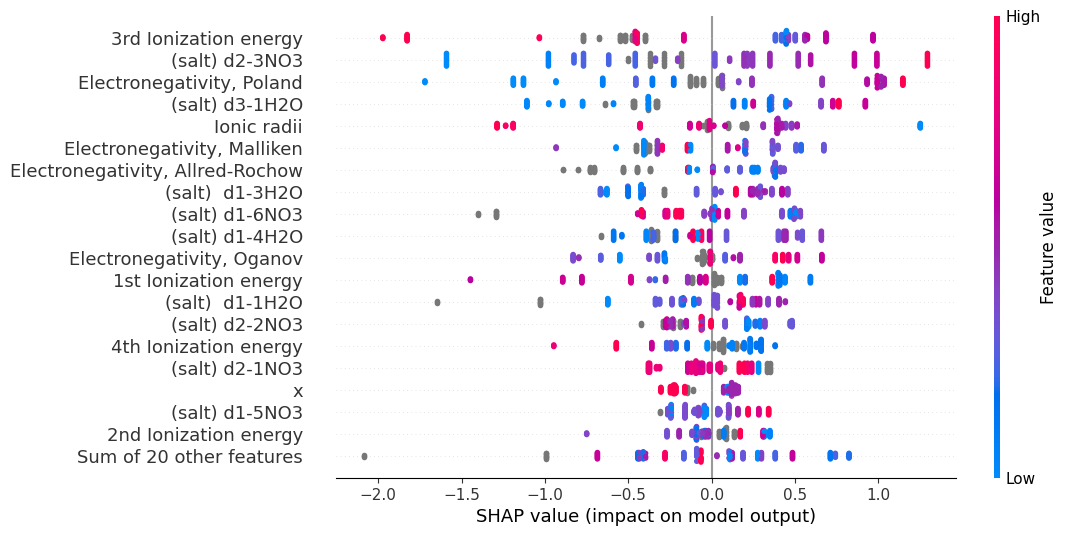

In [77]:
explain(xgb_salts, X_salts, 'salts_all_data', True, True)

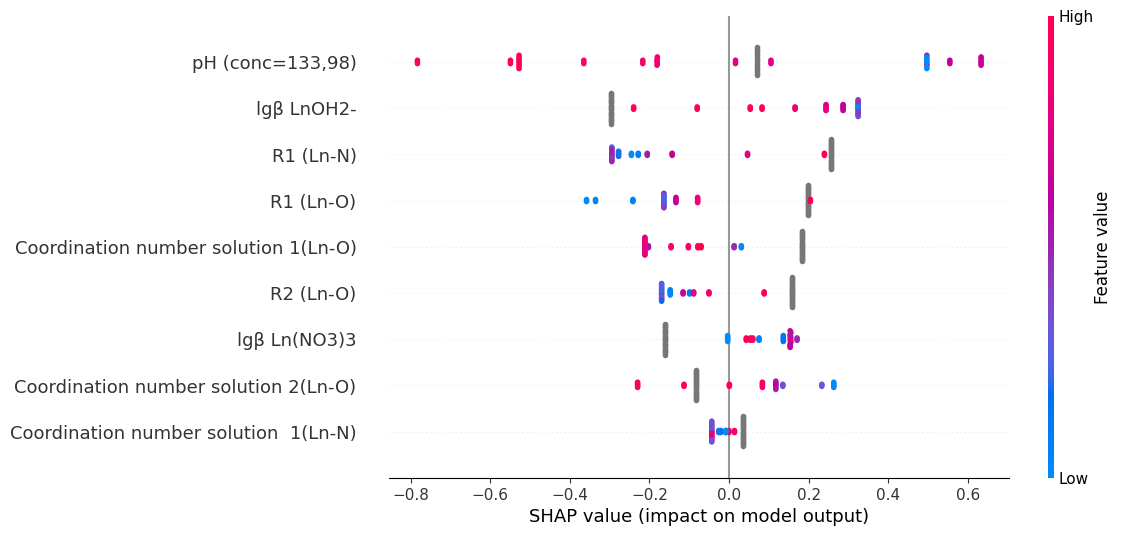

In [78]:

explain(xgb_solutions, X_solutions, 'solutions_all_data', True, True)